In [1]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.5/682.5 kB 8.9 MB/s eta 0:00:00


In [2]:
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 1.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
import os
import sys
from glob import glob
from tqdm.auto import tqdm

import trimesh
import gc

import numpy as np
import pandas as pd

import tensorflow as tf

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt
sys.path.append('/content/drive/MyDrive/mlcs/pointnet/')
from model_point import PointNet

import datetime
from tensorboardX import SummaryWriter


# File directory

ModelNet10

-batchtub

--train

---batchtub.0001.off

--test

-bed


In [20]:
class PointCloud(Dataset):
  def __init__(self, root_dir, n=50176, train=True):
    self.classes = os.listdir(root_dir)
    self.root_dir = root_dir
    self.n=n
    self.labels={}
    self.train=train
    self.traincount=0
    self.testcount=0
    for i in range(len(self.classes)):
      self.labels[self.classes[i]]=i

    trainls=[]
    for i in range(len(self.classes)):
      folderpath=os.path.join(self.root_dir, self.classes[i],'train')
      for j in os.listdir(folderpath):
        trainls.append(os.path.join(folderpath,j))
    self.trainfilepath = pd.DataFrame(trainls)

    testls=[]
    for i in range(len(self.classes)):
      folderpath=os.path.join(self.root_dir, self.classes[i],'test')
      for j in os.listdir(folderpath):
        testls.append(os.path.join(folderpath,j))
    self.testfilepath=pd.DataFrame(testls)

  def __len__(self):
    if self.train==True:
      return len(self.trainfilepath)
    else:
      return len(self.testfilepath)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx=idx.tolist()

    Islabel=np.zeros(10)
    if self.train==True:
      path=self.trainfilepath.iloc[idx][0]
      points=trimesh.load(self.trainfilepath.iloc[idx][0]).sample(self.n)
      for i in self.labels.keys():
        if i in path:
          Islabel[self.labels[i]]=1
    else:
      path=self.testfilepath.iloc[idx][0]
      points=trimesh.load(self.testfilepath.iloc[idx][0]).sample(self.n)
      for i in self.labels.keys():
        if i in path:
          Islabel[self.labels[i]]=1

    points = torch.Tensor(points)
    normalized_points = F.normalize(points,p=2,dim=0)
    Islabel = torch.tensor(Islabel)
    return normalized_points, Islabel  #(1024,3), (10)


In [21]:
# go to working directory (trainer_point.ipynb)
%cd '/content/drive/MyDrive/mlcs/pointnet'

/content/drive/MyDrive/mlcs/pointnet


In [22]:
pointcloudtrain_dataset=PointCloud(root_dir='./archive/ModelNet10/',n=1024,train=True)
pointcloudtest_dataset=PointCloud(root_dir='./archive/ModelNet10/',n=1024,train=False)

In [23]:
print(len(pointcloudtrain_dataset),len(pointcloudtest_dataset))

3991 908


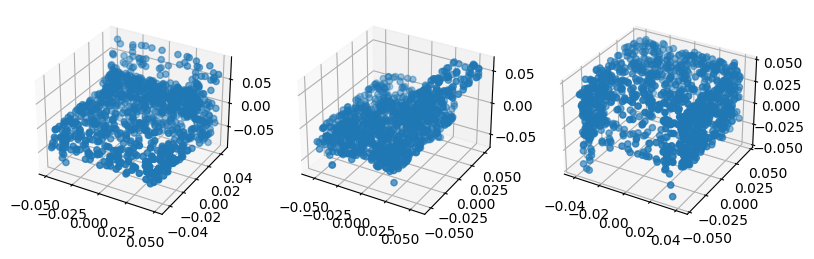

In [24]:
fig=plt.figure(figsize=plt.figaspect(0.5))

sample,label=pointcloudtrain_dataset[0]
ax=fig.add_subplot(1,3,1,projection='3d')  # col 1 row 3 and position for each = 1
surf=ax.scatter(sample[:,0],sample[:,1],sample[:,2])

sample,label=pointcloudtrain_dataset[200]
ax=fig.add_subplot(1,3,2,projection='3d')
ax.scatter(sample[:,0],sample[:,1],sample[:,2])

sample,label=pointcloudtrain_dataset[1000]
ax=fig.add_subplot(1,3,3,projection='3d')
ax.scatter(sample[:,0],sample[:,1],sample[:,2])

plt.show()

In [25]:
from torch.utils.data.dataloader import default_collate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=64

trainloader=DataLoader(pointcloudtrain_dataset,batch_size=BATCH_SIZE,shuffle=True)

testloader=DataLoader(pointcloudtest_dataset,batch_size=BATCH_SIZE,shuffle=False)

print(len(trainloader),len(testloader))

63 15


In [26]:
dataiter=iter(trainloader)
points,labels=next(dataiter)

In [27]:
print(points.shape)  # 64,1024,3
print(labels.shape)  # 64,10
print(points[0])
print(labels[0])

torch.Size([64, 1024, 3])
torch.Size([64, 10])
tensor([[ 0.0453,  0.0442, -0.0070],
        [ 0.0435, -0.0373, -0.0371],
        [ 0.0001,  0.0321,  0.0124],
        ...,
        [ 0.0480,  0.0420, -0.0230],
        [ 0.0539,  0.0447, -0.0257],
        [ 0.0250,  0.0442, -0.0249]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


In [13]:
model=PointNet(n=points.shape[1],classes=10,task='classification',device=device)
model.to(device)

PointNet(
  (input_tnet): InputTransformNet(
    (mlp1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (mlp2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (mlp3): Sequential(
      (0): Conv2d(128, 1024, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (maxpooling): MaxPool1d(kernel_size=1024, stride=1024, padding=0, dilation=1, ceil_mode=False)
    (fc1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (fc2): Sequential(
      (0): Linear(in_fe

In [28]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [30]:
file_name='/content/drive/MyDrive/tensorboard/point/runs/modelnet10_epoch3'
writer = SummaryWriter(file_name)

In [31]:
def orthogonal_loss(trans):
  D = trans.size()[1]
  I = torch.eye(D)[None, :, :]
  I = I.to(trans.device)
  reg_loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
  return reg_loss

In [32]:
def train(model, epochs, progress_interval):
  for i in range(1,epochs+1):
    train_loss=0

    model.train()
    for batch_i, data in enumerate(trainloader):
      inputs, labels = data  # (64,1024,3), (64,10)
      _, max_indices = torch.max(labels, dim=1) # (64,10)->(64,)
      labels = max_indices
      inputs,labels=inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.long)
      print(inputs.shape, labels.shape)
      optimizer.zero_grad()
      outputs, tnet_output =model(inputs)
      #print(outputs[0],labels)
      loss = criterion(outputs, labels)
      reg_loss = orthogonal_loss(tnet_output)
      print(reg_loss,loss)
      loss += reg_loss

      loss.backward()
      optimizer.step()

      train_loss+=loss.item()

      if (batch_i%progress_interval==0):
        print(f"Training Epoch:{i}, Batch:{batch_i+1}, Loss:{train_loss/(batch_i+1):.4f}")


    train_loss /= len(trainloader)
    print(f"Training Epoch:{i}, Average Loss:{train_loss:.4f}")
    writer.add_scalar("Loss/train",train_loss,i)

  return model


In [38]:
def test(model):
  model.eval()
  with torch.no_grad():
    test_loss=0
    total_cnt=0
    correct_cnt=0
    for batch_i, data in enumerate(testloader):
      inputs, labels = data
      _,max_indices = torch.max(labels, dim=1) # (64,10)->(64)
      labels = max_indices
      inputs,labels=inputs.to(device,dtype=torch.float), labels.to(device,dtype=torch.long)
      print(labels)
      outputs=model(inputs)
      loss=criterion(outputs,labels)
      _,pred_label=torch.max(F.softmax(outputs,dim=1),1)
      correct_cnt +=(pred_label==labels).sum().item()
      total_cnt += inputs.size(0)
      test_loss+=loss.item()

    total_loss = test_loss/len(testloader)
    acu=correct_cnt/total_cnt
    print(f"Test Loss:{total_loss}, Accuracy:{acu:.4f}")
    writer.add_scalar("Loss/test",total_loss)
    writer.add_scalar("accuracy",acu)


In [34]:
model = train(model, 3, 1)

torch.Size([64, 1024, 3]) torch.Size([64])
tensor(82.5767, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.6750, device='cuda:0', grad_fn=<NllLossBackward0>)
Training Epoch:1, Batch:1, Loss:85.2517
torch.Size([64, 1024, 3]) torch.Size([64])
tensor(64.4708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.4505, device='cuda:0', grad_fn=<NllLossBackward0>)
Training Epoch:1, Batch:2, Loss:76.0865
torch.Size([64, 1024, 3]) torch.Size([64])
tensor(62.6539, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.3882, device='cuda:0', grad_fn=<NllLossBackward0>)
Training Epoch:1, Batch:3, Loss:72.4050
torch.Size([64, 1024, 3]) torch.Size([64])
tensor(46.6802, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.3167, device='cuda:0', grad_fn=<NllLossBackward0>)
Training Epoch:1, Batch:4, Loss:66.5530
torch.Size([64, 1024, 3]) torch.Size([64])
tensor(41.2708, device='cuda:0', grad_fn=<MeanBackward0>) tensor(2.2669, device='cuda:0', grad_fn=<NllLossBackward0>)
Training Epoch:1, Batch:5, Loss:61.

In [39]:
test(model)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


TypeError: ignored

In [ ]:
writer.close()

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir=./runs --port=6007

In [ ]:
#Test Loss:3.3432503223419188, Accuracy:0.1101